In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # Suppress TensorFlow logging
import tensorflow as tf
tf.get_logger().setLevel('ERROR')  # Suppress TensorFlow warnings

In [3]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping

# Set the directory containing the cartoon faces dataset
dataset_dir = '/kaggle/input/cartoon-faces-googles-cartoon-set/cartoonset100k_jpg'

# Create the autoencoder model
def create_autoencoder():
    input_layer = Input(shape=(248, 248, 3))
    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2), padding='same')(x)  # 248x248 -> 124x124
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # 124x124 -> 62x62
    encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    
    # Decoder
    x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)  # 62x62 -> 124x124
    x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # 124x124 -> 248x248
    decoded = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

# Custom Sequence for data generation
class CartoonDataSequence(Sequence):
    def __init__(self, dataset_dir, batch_size=32):
        self.dataset_dir = dataset_dir
        self.batch_size = batch_size
        self.image_paths = self._get_image_paths()
        self.indexes = np.arange(len(self.image_paths))
        np.random.shuffle(self.indexes)

    def _get_image_paths(self):
        image_paths = []
        for subdir in os.listdir(self.dataset_dir):
            subdir_path = os.path.join(self.dataset_dir, subdir)
            for filename in os.listdir(subdir_path):
                image_paths.append(os.path.join(subdir_path, filename))
        return image_paths

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_paths = [self.image_paths[i] for i in batch_indexes]
        
        low_res_images = []
        high_res_images = []
        for path in batch_paths:
            img = Image.open(path).resize((248, 248))  # Resize to 248x248
            high_res_images.append(np.array(img) / 255.0)
            
            img_resized = img.resize((124, 124))  # Resize to 124x124
            img_resized_back = img_resized.resize((248, 248))  # Resize back to 248x248
            img_array = np.array(img_resized_back) / 255.0
            low_res_images.append(img_array)
        
        low_res_images = np.array(low_res_images)
        high_res_images = np.array(high_res_images)
        return low_res_images, high_res_images  # Return low-res as input and high-res as target

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

# Create the autoencoder model
autoencoder = create_autoencoder()

# Create data sequence
data_sequence = CartoonDataSequence(dataset_dir, batch_size=32)

# Set up early stopping
early_stopping = EarlyStopping(monitor='loss', patience=3)

# Train the autoencoder using the sequence
autoencoder.fit(
    data_sequence,
    epochs=15,
    callbacks=[early_stopping]
)


Epoch 1/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1505s 480ms/step - loss: 0.1485
Epoch 2/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1169s 373ms/step - loss: 0.1291
Epoch 3/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1153s 368ms/step - loss: 0.1252
Epoch 4/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1217s 389ms/step - loss: 0.1249
Epoch 5/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1252s 400ms/step - loss: 0.1237
Epoch 6/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1242s 396ms/step - loss: 0.1228
Epoch 7/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1271s 406ms/step - loss: 0.1223
Epoch 8/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1334s 426ms/step - loss: 0.1221
Epoch 9/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1238s 395ms/step - loss: 0.1219
Epoch 10/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1252s 400ms/step - loss: 0.1218
Epoch 11/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1229s 392ms/step - loss: 0.1220
Epoch 12/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1290s 412ms/step - loss: 0.1225
Epoch 13/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1302s 416ms/step - loss: 0.1220


In [94]:
# Function to reconstruct images
def reconstruct_images(dataset_dir, num_images=10):
    reconstructed_images = []
    original_images = []
    for subdir in os.listdir(dataset_dir):
        subdir_path = os.path.join(dataset_dir, subdir)
        for filename in os.listdir(subdir_path):
            if len(reconstructed_images) == num_images:
                break
            img_path = os.path.join(subdir_path, filename)
            img = Image.open(img_path)
            img_resized = img.resize((124, 124))  # Resize to 124x124
            img_resized_back = img_resized.resize((248, 248))  # Resize back to 248x248
            img_array = np.expand_dims(np.array(img_resized_back), axis=0)
            reconstructed_img = autoencoder.predict(img_array / 255)[0]
            reconstructed_images.append(reconstructed_img)
            original_images.append(np.array(img))
        if len(reconstructed_images) == num_images:
            break
    return original_images, reconstructed_images

In [95]:
# to get reconstructed images
original_images, reconstructed_images = reconstruct_images(dataset_dir, 10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [96]:
reconstructed_images[1].shape

(248, 248, 3)

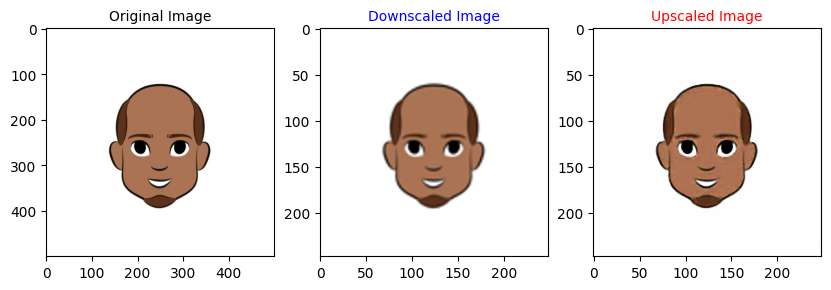

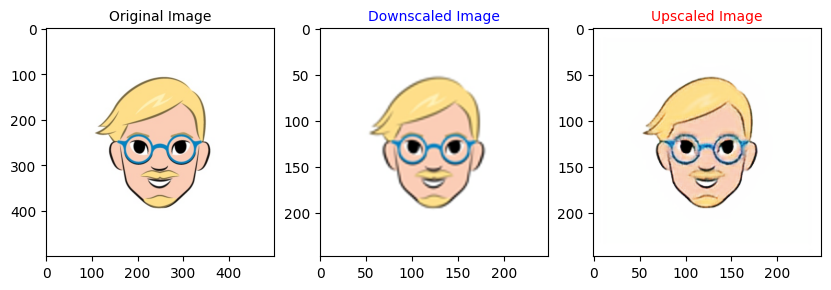

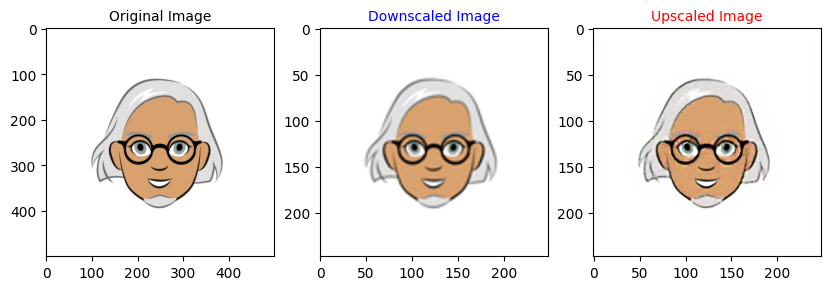

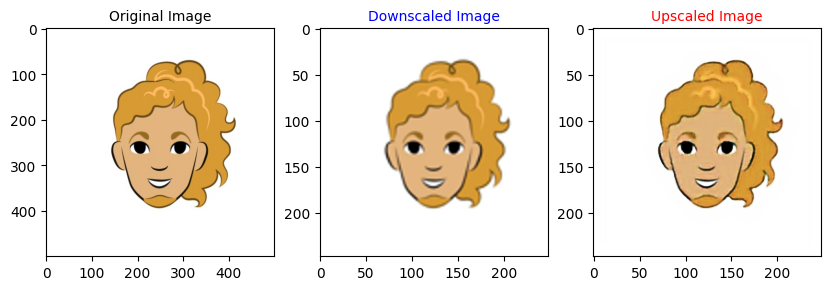

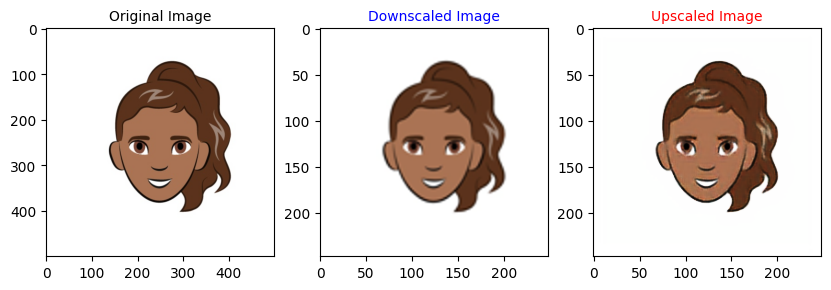

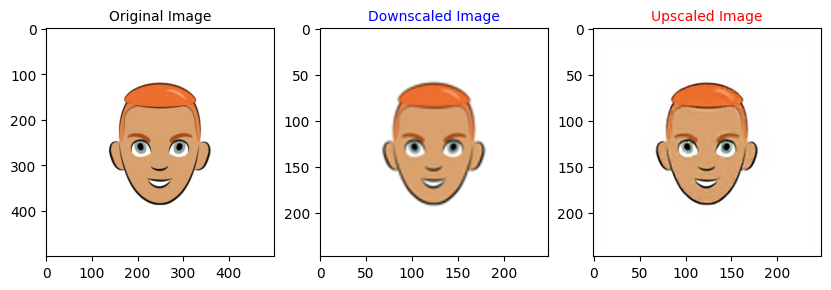

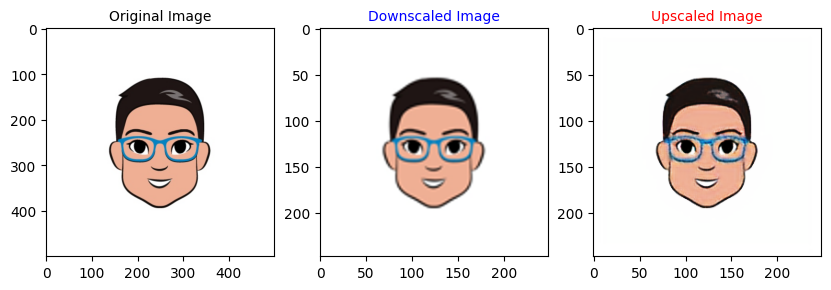

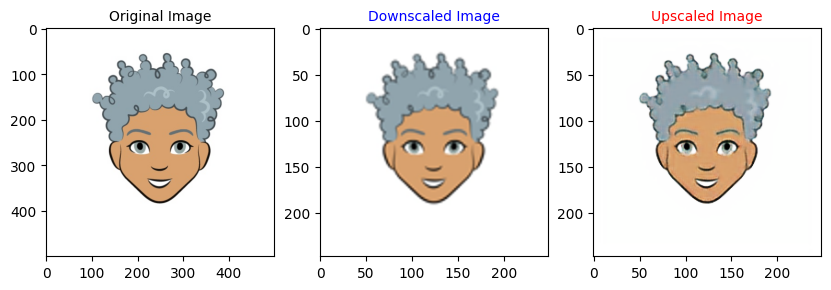

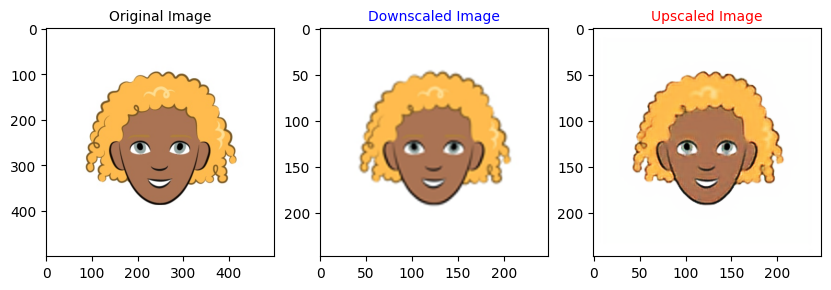

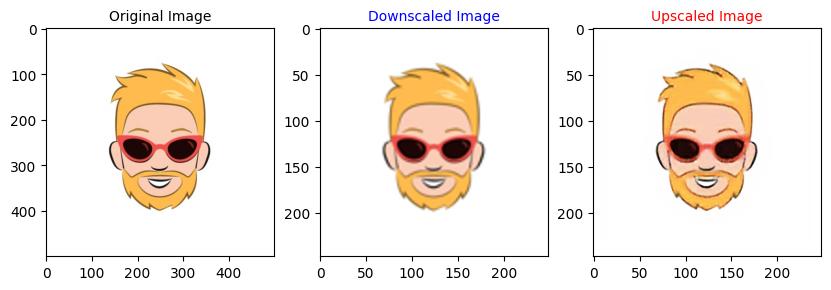

In [97]:
import matplotlib.pyplot as plt

def plot_images(original, downscaled, predicted):
    plt.figure(figsize=(10, 10))
    
    # Convert images back to original scale
    original = np.squeeze(original)
    downscaled = downscaled
    predicted = (predicted * 255).astype(np.uint8)
    
    plt.subplot(1, 3, 1)
    plt.title('Original Image', color='black', fontsize=10)
    plt.imshow(original)
    
    plt.subplot(1, 3, 2)
    plt.title('Downscaled Image', color='blue', fontsize=10)
    plt.imshow(downscaled)
    
    plt.subplot(1, 3, 3)
    plt.title('Upscaled Image', color='red', fontsize=10)
    plt.imshow(predicted)
    
    plt.show()

for i in range(10):
    original = original_images[i]
    downscaled = Image.fromarray(original).resize((248, 248)).resize((124, 124)).resize((248,248))
    downscaled = np.array(downscaled)
    plot_images(original, downscaled, reconstructed_images[i])
